In [1]:
from __future__ import division
import numpy as np
from scipy.special import factorial
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import ipywidgets
from IPython.display import display
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')
%config InlineBackend.figure_format = 'svg'


def mean_firing_rate(gain, stimulus, preferred_stimulus, std_tc, baseline):
    # Gaussian tuning curve that determines the mean firing rate (Poisson rate parameter) for a given stimulus
    return baseline + gain*stats.norm.pdf(preferred_stimulus, loc = stimulus, scale = std_tc)

def get_spikes(gain, stimulus, preferred_stimuli, std_tc, baseline):
    # produce a vector of spikes for some population given some stimulus
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.random.poisson(lambdas)
                
def likelihood(stimulus, r, gain, preferred_stimuli, std_tc, baseline):
    # returns p(r|s)
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.prod(lambdas**r)

def spikes_and_inference(r_V = True,
                         r_A = True,
                         show_tuning_curves = False,
                         show_spike_count = False,
                         show_likelihoods = True,
                         true_stimulus = 10,
                         number_of_neurons = 40,
                         r_V_gain = 15,
                         r_A_gain = 75,
                         r_V_tuning_curve_sigma = 10,
                         r_A_tuning_curve_sigma = 10,
                         tuning_curve_baseline = 0,
                         joint_likelihood = True,
                         r_V_plus_r_A = True,
                         cue = False):
    np.random.seed(7)
    max_s = 40
    preferred_stimuli = np.linspace(-max_s*2, max_s*2, number_of_neurons)
    n_hypothesized_s = 250
    hypothesized_s = np.linspace(-max_s, max_s, n_hypothesized_s)
    gains     = {'r1':    r_V_gain,
                 'r2':    r_A_gain,
                 'r1+r2': r_V_gain + r_A_gain}
    sigma_TCs = {'r1':    r_V_tuning_curve_sigma,
                 'r2':    r_A_tuning_curve_sigma,
                 'r1+r2': (r_V_tuning_curve_sigma + r_A_tuning_curve_sigma)/2}
    spikes    = {'r1':    get_spikes(gains['r1'], true_stimulus, preferred_stimuli, sigma_TCs['r1'], tuning_curve_baseline),
                 'r2':    get_spikes(gains['r2'], true_stimulus, preferred_stimuli, sigma_TCs['r2'], tuning_curve_baseline)}
    spikes['r1+r2'] = spikes['r1'] + spikes['r2']
    active_pops = []
    if r_V: active_pops.append('r1')
    if r_A: active_pops.append('r2')
    if r_V_plus_r_A: active_pops.append('r1+r2')

    colors = {'r1':    sns.xkcd_rgb['light purple'],
              'r2':    sns.xkcd_rgb['dark pink'],
              'r1+r2': sns.xkcd_rgb['royal blue'],
              'joint': sns.xkcd_rgb['gold']}
    nSubplots = show_spike_count + show_tuning_curves + show_likelihoods
    fig, axes = plt.subplots(nSubplots, figsize = (7, 1.5*nSubplots)) # number of subplots according to what's been requested
    if not isinstance(axes, np.ndarray): axes = [axes] # makes axes into a list even if it's just one subplot
    subplot_idx = 0
    
    def plot_true_stimulus_and_legend(subplot_idx):
        axes[subplot_idx].plot(true_stimulus, 0, 'k^', markersize = 12, clip_on = False, label = 'true rattlesnake location')
        axes[subplot_idx].legend(loc = 'center left', bbox_to_anchor = (1, 0.5), prop = fontP)
    
    if show_tuning_curves:
        for neuron in range(number_of_neurons):
            if r_V:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r1'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r1'],
                                                        tuning_curve_baseline),
                                       color = colors['r1'])
            if r_A:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r2'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r2'],
                                                        tuning_curve_baseline),
                                       color = colors['r2'])
        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('mean firing rate\n(spikes/s)')
        axes[subplot_idx].set_ylim((0, 4))
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].set_yticks(np.linspace(0, 4, 5))
        subplot_idx += 1

    if show_spike_count:
        idx = abs(preferred_stimuli) < max_s
        if r_V:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1'][idx], 'o', color = colors['r1'],
                                   clip_on = False,  label = '$\mathbf{r}_\mathrm{V}$',
                                   markersize=4)
        if r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r2'][idx], 'o', color = colors['r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{A}$',
                                   markersize=4)
        if r_V_plus_r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1+r2'][idx], 'o', color = colors['r1+r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{V}+\mathbf{r}_\mathrm{A}$',
                                   markersize=8, zorder=1)
        axes[subplot_idx].set_xlabel('preferred location')
        axes[subplot_idx].set_ylabel('spike count')
        axes[subplot_idx].set_ylim((0, 10))
        axes[subplot_idx].set_xlim((-40, 40))
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

    if show_likelihoods:
        if cue:
            var = 'c'
        else:
            var = '\mathbf{r}'
        likelihoods = {}
            
        for population in active_pops:
            likelihoods[population] = np.zeros_like(hypothesized_s)
            for idx, ort in enumerate(hypothesized_s):
                likelihoods[population][idx] = likelihood(ort, spikes[population], gains[population],
                                                          preferred_stimuli, sigma_TCs[population], tuning_curve_baseline)
            likelihoods[population] /= np.sum(likelihoods[population]) # normalize

        if r_V:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1'], color = colors['r1'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}|s)$'.format(var))
        if r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r2'], color = colors['r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{A}}|s)$'.format(var))
        if r_V_plus_r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1+r2'], color = colors['r1+r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}+{}_\mathrm{{A}}|s)$'.format(var, var))
        if joint_likelihood:
            product = likelihoods['r1']*likelihoods['r2']
            product /= np.sum(product)
            axes[subplot_idx].plot(hypothesized_s, product, color = colors['joint'],linewidth = 7,
                                   label = '$p({}_\mathrm{{V}}|s)\ p({}_\mathrm{{A}}|s)$'.format(var, var), zorder = 1)

        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('probability')
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].legend()
        axes[subplot_idx].set_yticks([])
        
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

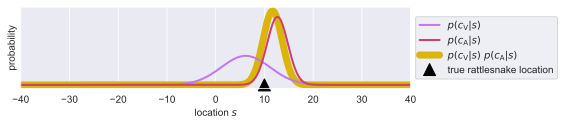

In [2]:
spikes_and_inference(show_likelihoods = True, r_V_plus_r_A = False, cue = True)

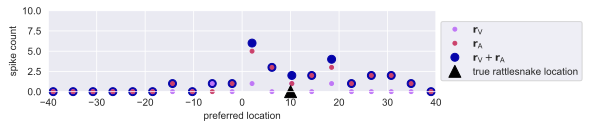

In [3]:
spikes_and_inference(show_spike_count = True, show_likelihoods = False)

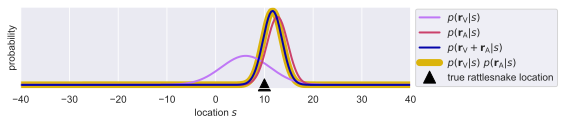

In [4]:
spikes_and_inference()

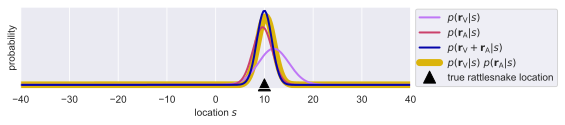

In [5]:
spikes_and_inference(r_V_tuning_curve_sigma = 7, r_A_tuning_curve_sigma = 10)

In [7]:
i = ipywidgets.interactive(spikes_and_inference,
              true_stimulus = (-40, 40, .1),
              number_of_neurons = (2, 200, 1),
              r_V_gain = (0, 100, 1),
              r_A_gain = (0, 100, 1),
              r_V_tuning_curve_sigma = (0.1, 50, .1),
              r_A_tuning_curve_sigma = (0.1, 50, .1),
              tuning_curve_baseline = (0, 20, .1));
display(ipywidgets.VBox(i.children[2:-1]))